**IMPORTANT** <br> <ul> <li> Do **NOT** replace or remove this notebook (ipynb file)! Each cell has unique nbgrader's metadata and ID which, if changed outside the nbgrader, cannot pass the tests. Do **NOT** change the name of the file!</li> <li> To receive any credit, don't forget to **SUBMIT** your notebook when you are done! You can have multiple submissions before the deadline; only the last one is saved, including its timestamp.</li> <li>Before submitting, **Validate** your notebook to check if your codes pass all visible tests. </li> <li>Make sure you fill in any cell with the comment `# your code here`. Remove or comment the command `fail()` (in R), or `raise NotImplementedError` (in Python) and place your code there </li> </ul>

In [ ]:
NAME = "Christian Olivares-Rodriguez"

---

# Convolutional Nets, Plus Autoencoder + Transfer Learning

In this homework, we'll briefly practice making a few convolutional nets to classify numbers and images. We'll also train an autoencoder and use it for transfer learning.

Note: You **must restart the kernel before validating**.

Also Note: Specified training times are much shorter than is optimal, but have been chosen so that the notebook will validate in a reasonable amount of time. You will get better results than those here if you just train for more epochs.

In [39]:
## RUN THIS CELL FIRST to import TensorFlow and some helper modules

# TensorFlow and tf.keras
import tensorflow as tf

# And the usual suspects
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Get the MNIST Numbers Data to Start

Run the following cells to get the MNIST data, hold out a part of the training set for validation, and rescale.

In [40]:
#Load as usual:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


## Hold out some of the training data for validation:
######

## All but last 5,000 will be train data; last 5,000 will be validation
X_train, y_train = train_images[:-5000], train_labels[:-5000]

X_valid, y_valid = train_images[-5000:], train_labels[-5000:]

#Rename the test data for consistency:
X_test, y_test = test_images, test_labels

In [41]:
## And rescale everything to be floats between 0 and 1:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

## Part 1: Reproduce (Almost) the LeNet-5 Architecture

The LeNet-5 model is a famous convolutional neural net (CNN) architecture for recognizing handwritten digits. The general model structure follows:

Layer  | Type            | Maps | Size     | Kernel size | Stride | Activation
-------|-----------------|------|----------|-------------|--------|-----------
 Out   | Fully connected | –    | 10       | –           | –      | RBF
 F6    | Fully connected | –    | 84       | –           | –      | tanh
 C5    | Convolution     | 120  | 1 × 1    | 5 × 5       | 1      | tanh
 S4    | Avg pooling     | 16   | 5 × 5    | 2 × 2       | 2      | tanh
 C3    | Convolution     | 16   | 10 × 10  | 5 × 5       | 1      | tanh
 S2    | Avg pooling     | 6    | 14 × 14  | 2 × 2       | 2      | tanh
 C1    | Convolution     | 6    | 28 × 28  | 5 × 5       | 1      | tanh
 In    | Input           | 1    | 32 × 32  | –           | –      | –
 

Or, using the figure from the original paper:

<img src="LeNet5.png" width="850">

Your task is to implement this model and use it to classify the MNIST numbers. The only difference is, we will use a **softmax** activation function for the output layer instead of an RBF function.

Also note that LeNet gives 32x32 as the input size: The MNIST numbers are 28x28, so the idea is we have zero-padding to get an effective 32x32 input size. That is, you'll need some zero-padding in your first convolutional layer.

The model you will implement is fully specified by the following table:

Layer  | Type            | Maps | Size     | Kernel size | Stride | Activation
-------|-----------------|------|----------|-------------|--------|-----------
 Out   | Fully connected | –    | 10       | –           | –      | softmax
 F6    | Fully connected | –    | 84       | –           | –      | tanh
 C5    | Convolution     | 120  | 1 × 1    | 5 × 5       | 1      | tanh
 S4    | Avg pooling     | 16   | 5 × 5    | 2 × 2       | 2      | tanh
 C3    | Convolution     | 16   | 10 × 10  | 5 × 5       | 1      | tanh
 S2    | Avg pooling     | 6    | 14 × 14  | 2 × 2       | 2      | tanh
 C1    | Convolution     | 6    | 28 × 28  | 5 × 5       | 1      | tanh
 In    | Input           | 1    | 28 × 28   | –           | –      | –
     |            |     | (32 x 32 w pad)  |         |      |

#### Specify the model

In the following cell, use either the sequential or functional Keras API to *create* the model as indicated above. Name the model `model`.

Initialize all layer weights using Glorot uniform initialization.

Do not compile or train just yet.

In [42]:

np.random.seed(123) #set the seed in numpy
tf.random.set_seed(123)  #set the seed in tensorflow

# your code here
from tensorflow.keras import layers, models, initializers

X_train = np.pad(X_train, ((0,0),(2,2),(2,2)), 'constant')
X_valid = np.pad(X_valid, ((0,0),(2,2),(2,2)), 'constant')
X_test = np.pad(X_test, ((0,0),(2,2),(2,2)), 'constant')

model = models.Sequential()

#C1
model.add(layers.Conv2D(filters = 6,
                        kernel_size = (5, 5),
                        strides = (1, 1),
                        activation = 'tanh',
                        input_shape = (32, 32, 1),
                        kernel_initializer=initializers.GlorotUniform()))

#S2
model.add(layers.AvgPool2D(pool_size = (2, 2), strides = (2, 2)))

#C3
model.add(layers.Conv2D(filters = 16,
                        kernel_size = (5, 5),
                        strides = (1, 1),
                        activation = 'tanh',
                        kernel_initializer = initializers.GlorotUniform()))

#S4
model.add(layers.AvgPool2D(pool_size = (2, 2), strides = (2, 2)))

#C5
model.add(layers.Conv2D(filters = 120,
                        kernel_size = (5, 5),
                        strides = (1, 1),
                        activation = 'tanh',
                        kernel_initializer = initializers.GlorotUniform()))

model.add(layers.Flatten())

#F6 
model.add(layers.Dense(units = 84,
                       activation = 'tanh',
                       kernel_initializer = initializers.GlorotUniform()))

model.add(layers.Dense(units = 10,
                       activation = 'softmax',
                       kernel_initializer = initializers.GlorotUniform()))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_10 (Avera  (None, 14, 14, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_16 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_11 (Avera  (None, 5, 5, 16)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_17 (Conv2D)          (None, 1, 1, 120)         48120     
                                                                 
 flatten_5 (Flatten)         (None, 120)              

In [43]:
#check whether there are 8 layers
assert len(model.layers) == 8 , "Sorry, wrong answer"

#check the shape of the first three layers:
assert model.layers[0].output_shape == (None, 28, 28, 6), "Sorry, wrong answer"
assert model.layers[1].output_shape == (None, 14, 14, 6), "Sorry, wrong answer"
assert model.layers[2].output_shape == (None, 10, 10, 16), "Sorry, wrong answer"

#Shape of the last layer:
assert model.layers[7].output_shape == (None, 10), "Sorry, wrong answer"

In [44]:
#check whether norm of vector of initial weights of the first layer is correct
assert abs(np.linalg.norm(model.layers[0].get_weights()[0].flatten()) - 1.2473539) < 1.e-4, "Sorry, wrong answer"

#And check the last layer:
assert abs(np.linalg.norm(model.layers[7].get_weights()[0].flatten()) - 4.389196) < 1.e-4, "Sorry, wrong answer"

### Compile and Train

Now, compile the model, using the appropriate loss function and the following:

1. Adam Optimizer (use Keras defaults)
2. Accuracy as the only metric

Fit the model using **5 epochs** with a **mini-batch size of 256**. Use the training and validation datasets constructed at the beginning of the notebook. This will take a couple moments.

Only run the fit *once* if you want your results to match the autograder (recreate the model before the fit if needed.)

**Save the training history as `history`.**

In [45]:
# your code here
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(X_train, y_train,epochs = 5, batch_size = 256, validation_data = (X_valid, y_valid), verbose = 1)

Epoch 1/5
215/215 [==============================] - 4s 15ms/step - loss: 0.4495 - accuracy: 0.8762 - val_loss: 0.1687 - val_accuracy: 0.9558
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1697 - accuracy: 0.9485 - val_loss: 0.1076 - val_accuracy: 0.9708
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1100 - accuracy: 0.9670 - val_loss: 0.0780 - val_accuracy: 0.9786
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0830 - accuracy: 0.9752 - val_loss: 0.0712 - val_accuracy: 0.9804
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0639 - accuracy: 0.9806 - val_loss: 0.0631 - val_accuracy: 0.9826


In [48]:
#Check the trained weights:
###

#check whether norm of vector of final weights of the first layer is correct
assert abs(np.linalg.norm(model.layers[0].get_weights()[0].flatten()) - 2.0671482) < 1.e-4, "Sorry, wrong answer"

#And check the last layer:
assert abs(np.linalg.norm(model.layers[7].get_weights()[0].flatten()) - 6.6404786) < 1.e-4, "Sorry, wrong answer"

### Plot the History

Make a quick plot of the training loss and accuracy, as well as the validation loss and accuracy.  Your plot should resemble the following:

<img src="history.png" width="450px">


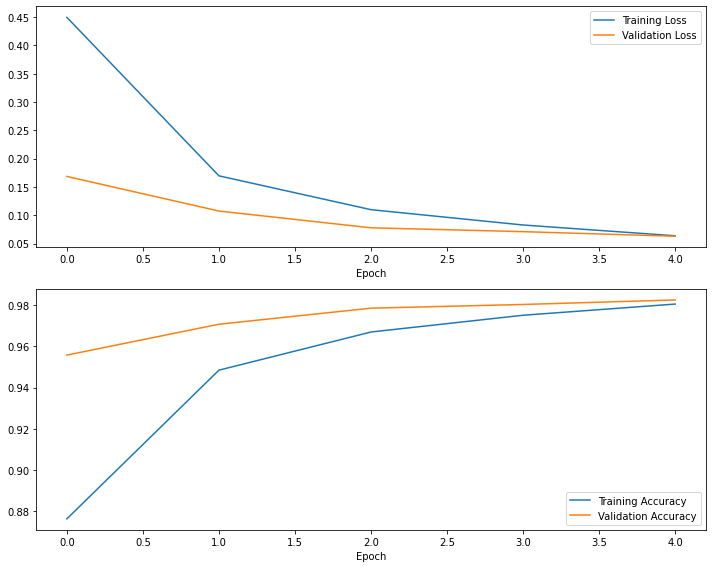

In [70]:
# your code here
plt.figure(figsize = (10, 8))

plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'],  label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(loc = 'lower right')
plt.tight_layout()


### Visualize the Filters

While not terribly informative, also take a moment to visualize the (six) trained filters of the first convolution layer. Your figure should look something like:

<img src="filters.png" width="425px">

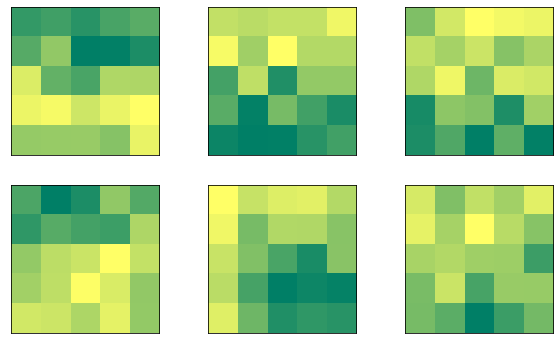

In [90]:
# your code here
filters, biases = model.layers[0].get_weights()

f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = filters.shape[3]
plt.figure(figsize = (10, 6))  

n_columns = 3
n_rows = n_filters // n_columns

for i in range(n_filters):
    f = filters[:, :, :, i]
    row = i // n_columns
    col = i % n_columns
    ax = plt.subplot(n_rows, n_columns, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(f[:, :, 0], cmap='summer')

### Accuracy on the Test Set

Determine the model accuracy on the test dataset.

Assign the result to the variable `test_acc`.

In [91]:
# your code here
test_loss, test_acc = model.evaluate(X_test, y_test, verbose = 1)

313/313 [==============================] - 1s 4ms/step - loss: 0.0633 - accuracy: 0.9807


In [92]:
#check whether the 3rd and 4th decimal digits of train_acc are 07 
assert np.mod(np.floor(test_acc * 10**4), 100) == 7


In [93]:
#check whether the answer is correct (hidden tests)


### Predictions on the Test Set

Predict the *class* (digit) for all instances in the testing dataset.

Assign the result to the variable `y_pred`.

In [94]:
# your code here
y_pred = np.argmax(model.predict(X_test), axis = 1)

In [95]:
#Check the first 10 values 
assert (y_pred[:10] == np.array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])).all()

In [25]:
#check whether the answer is correct (hidden tests)


### Plot Some Failures

Plot the first 16 misclassified digits in the test dataset, along with a barplot of the probabilities of each class. Color bar associated with the model-predicted class red in the case of a misclassification, and color the true label green. Color all other bars grey. That is, use the exact same method we used in HW4 to visualize prediction probabilities on the MNIST Fashion dataset.

So, adapt the code from HW4 to make the following plot (in essence):

<img src="misclass1.png" width="800px">

In [139]:
# your code here


## Make Some Modifications

Make a new model based on the (modified) LeNet architecture implemented above, but add the following layers:

1. Add a Batch Normalization Layer after each convolutional layer (after the activation function).
2. Add a Dropout Layer with 20% dropout before the hidden Dense layer.
3. Add a Dropout Layer with 40% dropout before the output layer.

Make the following changes to the existing layers:

1. Replace the average pooling layers with Max pooling layers.
2. Change the activation function for all hidden layers from tanh to ReLU.
3. Change weight initialization to He Normal for all layers with ReLU activation functions.

Also reset the numpy and tensorflow random seeds to 123.

Name this new model `model_mod`.

In [50]:

np.random.seed(123) #set the seed in numpy
tf.random.set_seed(123)  #set the seed in tensorflow

# your code here


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 batch_normalization_37 (Bat  (None, 28, 28, 6)        24        
 chNormalization)                                                
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 14, 14, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 batch_normalization_38 (Bat  (None, 10, 10, 16)       64        
 chNormalization)                                                
                                                     

In [51]:
#check whether there are 13 layers
assert len(model_mod.layers) == 13 , "Sorry, wrong answer"

#check the shape of the first three layers:
assert model_mod.layers[0].output_shape == (None, 28, 28, 6), "Sorry, wrong answer"
assert model_mod.layers[1].output_shape == (None, 28, 28, 6), "Sorry, wrong answer"
assert model_mod.layers[2].output_shape == (None, 14, 14, 6), "Sorry, wrong answer"

#Shape of a few more layers
assert model_mod.layers[7].output_shape == (None, 1, 1, 120), "Sorry, wrong answer"
assert model_mod.layers[8].output_shape == (None, 120), "Sorry, wrong answer"
assert model_mod.layers[9].output_shape == (None, 120), "Sorry, wrong answer"

AssertionError: Sorry, wrong answer

In [52]:
#check whether norm of vector of initial weights of the first layer is correct
assert abs(np.linalg.norm(model_mod.layers[0].get_weights()[0].flatten()) - 3.4778945) < 1.e-4, "Sorry, wrong answer"

#And check the last layer:
assert abs(np.linalg.norm(model_mod.layers[12].get_weights()[0].flatten()) - 4.389196) < 1.e-4, "Sorry, wrong answer"

IndexError: list index out of range

### Compile and Train Again

Compile the model using the same loss, optimizer, and metrics as above.

Train the model for **2 Epochs with a mini-batch size of 256**. Use the training and validation datasets constructed at the beginning of the notebook.

In [ ]:
# your code here
raise NotImplementedError

### Accuracy on the Test Set

Determine the modified model's accuracy on the test dataset. Assign the result to the variable `test_acc`.

In [ ]:
# your code here
raise NotImplementedError

In [ ]:
#check whether the 3rd and 4th decimal digits of train_acc are 50
assert np.mod(np.floor(test_acc * 10**4), 100) == 50


In [ ]:
#check whether the answer is correct (hidden tests)


### More Predictions on the Test Set

Predict the *class* (digit) for all instance in the testing dataset, using the modified model.

Assign the result to the variable `y_pred_mod`.


In [ ]:
# your code here
raise NotImplementedError

In [ ]:
#Check the first 10 values 
assert (y_pred_mod[:10] == np.array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])).all()

In [ ]:

#check whether the answer is correct (hidden tests)



### Plot Some More Failures

Plot the first 16 misclassified digits in the test dataset, making a graph of the probabilities of each class. Adapt your earlier code to reproduce (in essence):

<img src="misclass2.png" width="800px">


In [ ]:
# your code here
raise NotImplementedError

## Part 2: Autoencoder + Transfer Learning

We will download the CIFAR10 Dataset, and try out some unsupervised pretraining. Run the following cells to download the data and plot the first few entries of the training set:


In [ ]:
#Let's get the CIFAR10 dataset
from tensorflow.keras import datasets

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

#Normalize to between 0 and 1:
train_images, test_images = train_images / 255.0, test_images / 255.0


## Hold out some for validation, just like before:
###########

## All but last 5,000 will be train data; last 5,000 will be validation
X_train, y_train = train_images[:-5000], train_labels[:-5000]

X_valid, y_valid = train_images[-5000:], train_labels[-5000:]

#Rename the test data for consistency:
X_test, y_test = test_images, test_labels


#And our class names follow:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
#### Plot some of the images
#########
fig1, ax1 = plt.subplots(3, 8, figsize=(15,7))
ax1 = ax1.flatten()

#And plot:
for i in range(24):

    ax1[i].imshow(X_train[i])
    ax1[i].set_title(class_names[y_train[i][0]], fontweight='bold')
    
    ax1[i].set_axis_off()


### Make the Autoenconder

Now, build an **autoencoder** with the following structure, where Maps is the number of feature maps:

Layer  | Type            | Maps | Size     | Kernel size | Stride | Activation
-------|-----------------|------|----------|-------------|--------|-----------
 Reshape   | - | –    | 32 x32 x 3       | –           | –      | None
 Out   | Fully connected | –    | 3078       | –           | –      | None
 F7    | Fully connected | –    | 128       | –           | –      | ReLU
 D6    | Dropout 40%    | -  | -    | -      | -      | -
 C5    | Convolution     | 64  | 5 × 5    | 3 × 3       | 1      | ReLU
 S4    | Max pooling     | 32   | 7 × 7    | 2 × 2       | 2      | -
 C3    | Convolution     | 32   | 14 × 14  | 3 × 3       | 1      | ReLU
 S2    | Max pooling     | 32    | 16 × 16  | 2 × 2       | 2      | -
 C1    | Convolution     | 32    | 32 × 32  | 5 × 5       | 1      | ReLU
 In    | Input           | 1    | 32 × 32 x 3  | –           | –      | –
 
- Include zero-padding only for the first convolutional layer.

- Use He Normal weight initialization for layers with a ReLU activation function.

- Call your model `model_auto`

Again, reset the random number seeds to 123.

In [ ]:
np.random.seed(123) #set the seed in numpy
tf.random.set_seed(123)  #set the seed in tensorflow

# your code here
raise NotImplementedError


In [ ]:
#check whether there are 10 layers
assert len(model_auto.layers) == 10 , "Sorry, wrong answer"

#check the shape of the first three layers:
assert model_auto.layers[0].output_shape == (None, 32, 32, 32), "Sorry, wrong answer"
assert model_auto.layers[1].output_shape == (None, 16, 16, 32), "Sorry, wrong answer"
assert model_auto.layers[2].output_shape == (None, 14, 14, 32), "Sorry, wrong answer"

#Shape of a few more layers
assert model_auto.layers[6].output_shape == (None, 1600), "Sorry, wrong answer"
assert model_auto.layers[7].output_shape == (None, 128), "Sorry, wrong answer"
assert model_auto.layers[8].output_shape == (None, 3072), "Sorry, wrong answer"
assert model_auto.layers[9].output_shape == (None, 32, 32, 3), "Sorry, wrong answer"

In [ ]:

#check whether norm of vector of initial weights of the first layer is correct
assert abs(np.linalg.norm(model_auto.layers[0].get_weights()[0].flatten()) - 7.9769735) < 1.e-4, "Sorry, wrong answer"

#And check layer 8:
assert abs(np.linalg.norm(model_auto.layers[8].get_weights()[0].flatten()) - 15.683301) < 1.e-4, "Sorry, wrong answer"

### Compile and Train

Compile the model using mean square error as your loss function, and the Adam optimizer.

Train the model for **3 Epochs with a mini-batch size of 128**. Use the training and validation datasets constructed at the beginning of this section.

In [ ]:
# your code here
raise NotImplementedError

### Visualize Some Output

Plot the input image and autoencoder output for the first 12 entries of the *validation* dataset.  Your results should look something like the following:

<img src="auto_results.png" width="1000px">

In [ ]:
# your code here
raise NotImplementedError

### And Now for the Transfer Learning: Setup

Clone `model_auto`, and set all the clone weights to those of the original model (`model_auto`).  Then, do the following:

1. Set your random number seeds to 123
2. Drop the top two layers of the net
3. Replace these with a Dense output layer with 10 neurons, and softmax activation function
4. Make the first four layers (First two convolutional layers and associated Max pool layers) **untrainable**

Name this final model `model_transfer`.

In [ ]:
np.random.seed(123) #set the seed in numpy
tf.random.set_seed(123)  #set the seed in tensorflow

# your code here
raise NotImplementedError
    

In [ ]:
#check whether there are 9 layers
assert len(model_transfer.layers) == 9 , "Sorry, wrong answer"

#check the shape of the first few and last few layers:
assert model_transfer.layers[0].output_shape == (None, 32, 32, 32), "Sorry, wrong answer"
assert model_transfer.layers[1].output_shape == (None, 16, 16, 32), "Sorry, wrong answer"

#Shape of a few more layers
assert model_transfer.layers[6].output_shape == (None, 1600), "Sorry, wrong answer"
assert model_transfer.layers[7].output_shape == (None, 128), "Sorry, wrong answer"
assert model_transfer.layers[8].output_shape == (None, 10), "Sorry, wrong answer"


In [ ]:
#check whether norm of vector of initial weights of the first layer is correct
assert abs(np.linalg.norm(model_transfer.layers[0].get_weights()[0].flatten()) - 7.9397416) < 1.e-4, "Sorry, wrong answer"

#Third layer:
assert abs(np.linalg.norm(model_transfer.layers[2].get_weights()[0].flatten()) - 7.942527) < 1.e-4, "Sorry, wrong answer"

#And check layer 9:
assert abs(np.linalg.norm(model_transfer.layers[8].get_weights()[0].flatten()) - 4.350016) < 1.e-4, "Sorry, wrong answer"

### Compile, Train, and Predict

Compile the model using the appropriate loss function, Adam optimizer, and track accuracy as a metric.

Then, train `model_transfer` on the training data for **3 epochs with mini-batch size of 128**. Use the training and validation data loaded earlier.

In [ ]:
# your code here
raise NotImplementedError

In [ ]:
#check whether norm of vector of initial weights of the first layer is correct
assert abs(np.linalg.norm(model_transfer.layers[0].get_weights()[0].flatten()) - 7.9397416) < 1.e-4, "Sorry, wrong answer"

#Third layer:
assert abs(np.linalg.norm(model_transfer.layers[2].get_weights()[0].flatten()) - 7.942527) < 1.e-4, "Sorry, wrong answer"

#And check layer 7:
assert abs(np.linalg.norm(model_transfer.layers[7].get_weights()[0].flatten()) - 23.793957) < 1.e-4, "Sorry, wrong answer"

#And check layer 8:
assert abs(np.linalg.norm(model_transfer.layers[8].get_weights()[0].flatten()) - 5.154296) < 1.e-4, "Sorry, wrong answer"

### Final Accuracy on the Test Set

Determine the accuracy of the newly trained `model_transfer` on the test dataset. Assign the result to the variable `test_acc`.


In [ ]:
# your code here
raise NotImplementedError

In [ ]:
#check whether the 3rd and 4th decimal digits of train_acc are 28
assert np.mod(np.floor(test_acc * 10**4), 100) == 28

In [ ]:
#check whether the answer is correct (hidden tests)
